# Reinforcement Learning (DQN) - Cartpole Task

* The goal is for agent to learn keep the pole attached to a cart upright as long as possible. The agent does so by choosing between two actions: 'move the cart left or right'.

* In reinforcement learning the agent learns how to act or take action by trail and error. In other words, by trying out and action and receving a feedback/reward. It uses the feedback/reward to learn if taking an action in a particular senario (state) was good or bad. The model aim to maximise the total accumulated reward. 

* Current version just uses CPU.

### imports

In [6]:
import random
import gym
import numpy as np
from time import time
from keras.callbacks import TensorBoard
from collections import deque, namedtuple
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Dropout
from keras.optimizers import Adam
from keras import backend as K

import tensorflow as tf

ImportError: cannot import name np_utils

### Hyperparameters

In [10]:
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.99
TARGET_UPDATE = 100
LEARNING_RATE = 0.001
EPISODES = 100

### MDP transition represented as a named tuple

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

### Replay memory (a database to store input data and to sample from to create a training batch)

In [4]:
class ReplayMemory(object):
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen = capacity)
        
    def add(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size=10):
        return random.sample(self.memory, batch_size)
    
    def get_memory(self):
        return self.memory
    
    def __len__(self):
        return len(self.memory)


### Define Huber Loss Function.

In [5]:
def _huber_loss(y_true, y_pred, clip_delta=1.0):
    error = y_true - y_pred
    cond  = K.abs(error) <= clip_delta
    squared_loss = 0.5 * K.square(error)
    quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)
    return K.mean(tf.where(cond, squared_loss, quadratic_loss))


### Q-network

In [6]:
class Network(object):
    def __init__(self, state_size, action_size):

        # create the neural network.
        states_input = Input((state_size,), name='states')
        actions_input = Input((action_size,), name='mask')

        fc1 = Dense(24, activation='tanh')(states_input)
        #dropout_1 = Dropout(0.2)(fc1)
        fc2 = Dense(24, activation='tanh')(fc1)
        #dropout_2 = Dropout(0.2)(fc2)
        out = Dense(action_size, activation='linear')(fc2)
        filtered_output = Multiply()([out, actions_input])
        self.model = Model(inputs=[states_input, actions_input], outputs=filtered_output)
        self.model.compile(loss=_huber_loss,optimizer=Adam(lr=LEARNING_RATE, clipnorm=1.))
    
    def get_model(self):
        return self.model
        

#Test
net = Network(4, 2)
model = net.get_model()
print(model.summary())  

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
states (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           250         states[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50)           0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            102         dropout_1[0][0]                  
__________________________________________________________________________________________________
mask (Inpu

In [12]:
class DQN(object):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        #self.tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
        self.action_size = self.env.action_space.n
        self.network = Network(self.state_size, self.action_size)
        self.target_net = Network(self.state_size, self.action_size)
        self.memory = ReplayMemory()
        self.steps = 0
        self.epsilon = EPS_START
        self.duration = [0] * 100

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_net.get_model().set_weights(self.network.get_model().get_weights())
        
    def select_action(self, state):
        if self.epsilon > EPS_END:
            self.epsilon *= EPS_DECAY        
        self.steps += 1
        #Epsilon greedy exploration/exploitation.
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.network.get_model().predict([state, np.ones((1,2))])
        return np.argmax(act_values[0])
    
    def exploit_action(self, state):
        act_values = self.network.get_model().predict([state, np.ones((1,2))])
        return np.argmax(act_values[0])
    
    def train(self):
        
        #Check if we have generated enough data to train.
        if len(self.memory) < BATCH_SIZE:
            return
        
        #sample the minibatch to train network on.
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        state_batch = np.asarray(batch.state).reshape(BATCH_SIZE,self.state_size)
        action_batch = np.asarray(batch.action).reshape(BATCH_SIZE,-1)
        reward_batch = np.asarray(batch.reward).reshape(BATCH_SIZE,-1)
        next_state_batch = np.asarray(batch.next_state).reshape(BATCH_SIZE,self.state_size)
        done_batch = np.asarray(batch.done).reshape(BATCH_SIZE,-1)
        
        #one hot encoding of action space.
        one_hot_targets = (np.eye(self.action_size)[action_batch]).reshape(BATCH_SIZE,-1)
        
        # Compute max V(s_{t+1}) for all next states.
        next_state_values = self.target_net.get_model().predict([next_state_batch, np.ones(one_hot_targets.shape)])
        
        # Compute the expected Q values
        end_multiplier = -(done_batch - 1) 
        expected_state_action_values = ((np.max(next_state_values, axis=1, keepdims=True) * GAMMA)*end_multiplier) + reward_batch
        # Fit the keras model.
        model.fit([state_batch, one_hot_targets], one_hot_targets * expected_state_action_values,
                   epochs=1, batch_size=BATCH_SIZE, verbose=1)
        #callbacks=[self.tensorboard]  
        
    def run(self, episode_no):
        #reset the environment to start a fresh trial.
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size])
        self.steps = 0
        total_reward = 0
        while True:
            action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action)
            next_state = np.reshape(next_state, [1, self.state_size])
            if done and self.steps < 195:
                reward = -100
            total_reward += reward
            #add transition to replay memory.
            self.memory.add(state, action, next_state, reward, done)
            
            # Move to the next state
            state = next_state
            
            if done:
                print("{2} Episode {0} finished after {1} steps  and with total reward {3}"
                      .format(episode_no, self.steps, '\033[92m' if self.steps >= 195 else '\033[99m',
                              total_reward))
                break
        self.duration[(episode_no%100)] = self.steps
        #train for mini batch.
        self.train()

        if episode_no % TARGET_UPDATE == 0:
            self.update_target_model()

    def test(self, number_of_episodes):
        for e in range(number_of_episodes):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            t = 0
            total_reward = 0
            while True:
                t += 1
                self.env.render()
                action = self.exploit_action(state)
                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward
                state = np.reshape(next_state, [1, self.state_size])
                if done:
                    break
            
            print("number of steps : " + str(t))
            print("total_reward : " + str(total_reward))
            
            
        
            
            
agent = DQN()

agent.update_target_model()

for i in range(500):
    agent.run(i)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
 Episode 0 finished after 65 steps  and with total reward -36.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7923
 Episode 1 finished after 63 steps  and with total reward -38.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 1.5732
 Episode 2 finished after 59 steps  and with total reward -42.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.0092
 Episode 3 finished after 69 steps  and with total reward -32.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.7917
 Episode 4 finished after 88 steps  and with total reward -13.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.0050
 Episode 5 finished after 64 steps  and with total reward -37.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7875
 Episode 6 finished after 79 steps  and wit

 Episode 55 finished after 80 steps  and with total reward -21.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.0041
 Episode 56 finished after 74 steps  and with total reward -27.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.0037
 Episode 57 finished after 65 steps  and with total reward -36.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 1.5688
 Episode 58 finished after 89 steps  and with total reward -12.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.0026
 Episode 59 finished after 85 steps  and with total reward -16.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 1.5769
 Episode 60 finished after 66 steps  and with total reward -35.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.0049
 Episode 61 finished after 63 steps  and with total reward -38.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss:

 Episode 110 finished after 44 steps  and with total reward -57.0
Epoch 1/1
64/64 [==============================] - 0s 47us/step - loss: 1.5651
 Episode 111 finished after 52 steps  and with total reward -49.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.7892
 Episode 112 finished after 87 steps  and with total reward -14.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.0032
 Episode 113 finished after 65 steps  and with total reward -36.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7839
 Episode 114 finished after 60 steps  and with total reward -41.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7868
 Episode 115 finished after 91 steps  and with total reward -10.0
Epoch 1/1
64/64 [==============================] - 0s 47us/step - loss: 0.0037
 Episode 116 finished after 52 steps  and with total reward -49.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step 

 Episode 165 finished after 73 steps  and with total reward -28.0
Epoch 1/1
64/64 [==============================] - 0s 47us/step - loss: 0.0014
 Episode 166 finished after 75 steps  and with total reward -26.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7852
 Episode 167 finished after 61 steps  and with total reward -40.0
Epoch 1/1
64/64 [==============================] - 0s 15us/step - loss: 0.0023
 Episode 168 finished after 61 steps  and with total reward -40.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.7893
 Episode 169 finished after 73 steps  and with total reward -28.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 2.3570
 Episode 170 finished after 83 steps  and with total reward -18.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.0020
 Episode 171 finished after 77 steps  and with total reward -24.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step 

 Episode 220 finished after 71 steps  and with total reward -30.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 1.5766
 Episode 221 finished after 61 steps  and with total reward -40.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7830
 Episode 222 finished after 79 steps  and with total reward -22.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.0022
 Episode 223 finished after 92 steps  and with total reward -9.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.0027
 Episode 224 finished after 79 steps  and with total reward -22.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 1.5732
 Episode 225 finished after 57 steps  and with total reward -44.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.0015
 Episode 226 finished after 62 steps  and with total reward -39.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step -

 Episode 275 finished after 67 steps  and with total reward -34.0
Epoch 1/1
64/64 [==============================] - 0s 47us/step - loss: 0.7849
 Episode 276 finished after 71 steps  and with total reward -30.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.0028
 Episode 277 finished after 87 steps  and with total reward -14.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 1.5740
 Episode 278 finished after 73 steps  and with total reward -28.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7921
 Episode 279 finished after 84 steps  and with total reward -17.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 1.5718
 Episode 280 finished after 52 steps  and with total reward -49.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.0031
 Episode 281 finished after 99 steps  and with total reward -2.0
Epoch 1/1
64/64 [==============================] - 0s 15us/step -

 Episode 330 finished after 70 steps  and with total reward -31.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.0027
 Episode 331 finished after 74 steps  and with total reward -27.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7907
 Episode 332 finished after 61 steps  and with total reward -40.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.0017
 Episode 333 finished after 58 steps  and with total reward -43.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7917
 Episode 334 finished after 65 steps  and with total reward -36.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.0022
 Episode 335 finished after 84 steps  and with total reward -17.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7861
 Episode 336 finished after 85 steps  and with total reward -16.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step 

 Episode 385 finished after 80 steps  and with total reward -21.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.7881
 Episode 386 finished after 74 steps  and with total reward -27.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.7903
 Episode 387 finished after 65 steps  and with total reward -36.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 1.5760
 Episode 388 finished after 65 steps  and with total reward -36.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 1.5747
 Episode 389 finished after 65 steps  and with total reward -36.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7877
 Episode 390 finished after 60 steps  and with total reward -41.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.7888
 Episode 391 finished after 85 steps  and with total reward -16.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step 

 Episode 440 finished after 80 steps  and with total reward -21.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.7873
 Episode 441 finished after 75 steps  and with total reward -26.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 2.3572
 Episode 442 finished after 61 steps  and with total reward -40.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7927
 Episode 443 finished after 71 steps  and with total reward -30.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 1.5710
 Episode 444 finished after 69 steps  and with total reward -32.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.7840
 Episode 445 finished after 79 steps  and with total reward -22.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 0.7872
 Episode 446 finished after 70 steps  and with total reward -31.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step 

 Episode 495 finished after 89 steps  and with total reward -12.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 1.5664
 Episode 496 finished after 68 steps  and with total reward -33.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 1.5772
 Episode 497 finished after 93 steps  and with total reward -8.0
Epoch 1/1
64/64 [==============================] - 0s 31us/step - loss: 1.5704
 Episode 498 finished after 69 steps  and with total reward -32.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 0.7827
 Episode 499 finished after 83 steps  and with total reward -18.0
Epoch 1/1
64/64 [==============================] - 0s 16us/step - loss: 1.5624


In [ ]:
agent.test(10)
print('Complete')


In [ ]:
agent.network.get_model().save_weights("cart.h5")

<IPython.core.display.Javascript object>


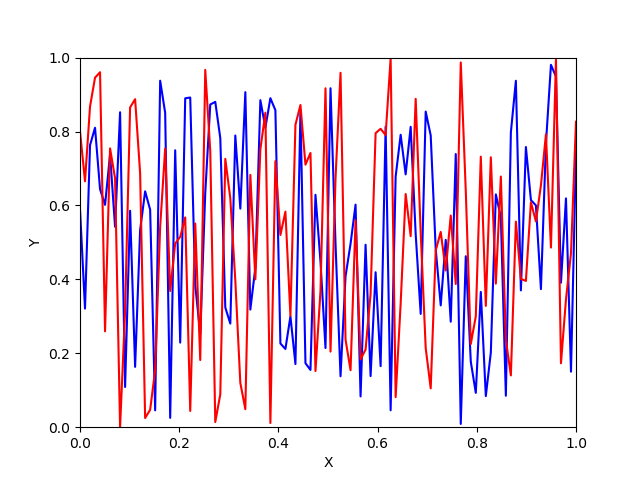

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

def pltsin(ax, colors=['b']):
    x = np.linspace(1,episodes,episodes)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            y = np.random.random(size=(100,1))
            line.set_ydata(y)
    else:
        for color in colors:
            y = np.random.random(size=(100,1))
            ax.plot(x, y, color)
    fig.canvas.draw()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
for f in range(5):
    pltsin(ax, ['b', 'r'])
    time.sleep(1)